In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
url = 'https://raw.githubusercontent.com/aliceblueberry/covid19_sura/master/flight%20data.csv'
df = pd.read_csv(url)
df = df.drop(df.columns[[1,2,3,4,5,7,8,9,10,12,13,14,15,16]], axis = 1)
df = df.loc[df['PASSENGERS']>0]

In [3]:
df = df.groupby(['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']).sum().reset_index()
df.to_csv('clean_flight.csv')

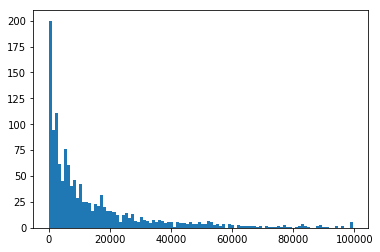

In [4]:
#show distribution of flight distribution across states in March 2020
plt.hist(df[df['PASSENGERS']<100000]['PASSENGERS'], bins = 100)
plt.show()

In [5]:
def normalize(c):
    upper = c.max()
    lower = c.min()
    y = (c - lower)/(upper-lower)
    return y

In [6]:
df_normalized = df.copy()
df_normalized['PASSENGERS'] = normalize(np.log(df_normalized['PASSENGERS']))
df_normalized = df_normalized.rename(columns={'PASSENGERS': 'PASSENGERS_NORMALIZED'})

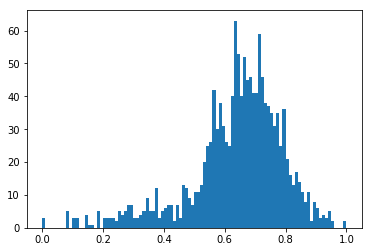

In [7]:
plt.hist(df_normalized['PASSENGERS_NORMALIZED'], bins = 100)
plt.show()

In [78]:
#April case data: positive, negative, total test results.
url = 'https://raw.githubusercontent.com/aliceblueberry/covid19_sura/master/data/case_data_apr.csv'
df_t = pd.read_csv(url)
df_t = df_t.set_index('state')
df_t.drop(['AS','DC','GU','MP','VI'], inplace = True)

In [4]:
#df_pos = df_t[df_t.columns[0:2]]
#dict?
#pos = df_pos.to_dict()

In [75]:
#feature: positive rate in testing
df_t['pos_rate_sample'] = df_t['positive'].div(df_t['totalTestResults'].values, axis = 0)

In [25]:
#population
url = 'https://raw.githubusercontent.com/aliceblueberry/covid19_sura/master/state_population_19.csv'
df_p = pd.read_csv(url)
#feature: population of states
df_p = df_p.drop(['States'], axis = 1)
df_p = df_p.dropna()
df_p.sort_values('Abr', axis = 0, ascending = True, inplace = True)
#reindex
df_p.drop(df_p.loc[df_p['Abr']=='DC'].index, inplace=True)
state_list = df_p['Abr'].tolist()

In [26]:
#string to int
df_p['Population'] = df_p['Population'].str.replace(",","")
df_p['Population'] = pd.to_numeric(df_p['Population'])

In [80]:
#april infection rate: cases per 100,000 people, later as label
april = df_t.drop(['positive','negative','totalTestResults'], axis = 1)
april['infect_rate'] = df_t['positive'].div(df_p['Population'].values, axis = 0)*100000
april = april.to_dict()

{'infect_rate': {'AK': 48.52743166859182, 'AL': 143.15184925716653, 'AR': 107.85988752085953, 'AZ': 105.07346280944842, 'CA': 123.80219660128968, 'CO': 256.27151513804415, 'CT': 776.9360503095543, 'DE': 486.15475618322307, 'FL': 156.8601012294731, 'GA': 246.34037845153196, 'HI': 43.294874112914165, 'IA': 226.46090261071862, 'ID': 111.02002445350337, 'IL': 417.60375245199566, 'IN': 264.92008058561373, 'KS': 145.47007291352733, 'KY': 101.59651344223268, 'LA': 602.3282597594128, 'MA': 902.5023275289108, 'MD': 359.62869354646625, 'ME': 81.46036488292025, 'MI': 475.675179888928, 'MN': 143.91009909866457, 'MO': 123.21122137807563, 'MS': 228.98719116549609, 'MT': 42.38485447866629, 'NC': 100.19942632038415, 'ND': 140.0148544344161, 'NE': 195.61540274854113, 'NH': 151.0615123360773, 'NJ': 1335.8417237190379, 'NM': 153.23137938286814, 'NV': 162.26450868072916, 'NY': 1564.608145521532, 'OH': 154.22059867740032, 'OK': 91.43357381188794, 'OR': 59.51058589001637, 'PA': 357.4678903411025, 'PR': 48.1

In [39]:
#march case data, as parameter
url = 'https://raw.githubusercontent.com/aliceblueberry/covid19_sura/master/case_data_march.xlsx'
march = pd.read_excel(url)
march = march.set_index('state')
march = march.drop(['date'], axis=1)
march.drop(['AS','DC','GU','MP','VI'], inplace = True)
march['infect_rate'] = march['positive'].div(df_p['Population'].values, axis = 0)*100000

In [42]:
#weekly increase of cases in last 2 weeks of March
url = 'https://raw.githubusercontent.com/aliceblueberry/covid19_sura/master/data/march_weekly.csv'
march_weekly = pd.read_csv(url)
march_weekly = march_weekly.set_index('state')
march_weekly.drop(['AS','DC','GU','MP','VI'], inplace = True)
march_weekly['positive'] = march_weekly['positive'].astype(int)

In [43]:
week1 = march_weekly[march_weekly['date'] == 20200317]
week2 = march_weekly[march_weekly['date'] == 20200324]
week3 = march_weekly[march_weekly['date'] == 20200331]

In [44]:
d1 = []
for i in range(week1.shape[0]):
    d1.append(week2['positive'][i]-week1['positive'][i])
diff1 = np.array(d1)

In [45]:
d2 = []
for i in range(week2.shape[0]):
    d2.append(week3['positive'][i]-week2['positive'][i])
diff2 = np.array(d2)

In [46]:
#features collection
features = pd.DataFrame(columns = ['state', 'infect_rate_march','march_inc_1','march_inc_2','pos_rate_sample'])

In [76]:
#state: list of all states
features['state'] = df_p['Abr'].values
#infect_rate_march: number of people infected covid-19 per 100,000 people in all states, by the end of March.
features['infect_rate_march'] = march['infect_rate'].values
#march_inc_1, march_inc_2: number of new infected people from March 17-24, March 24-31, respectively/
features['march_inc_1'] = diff1
features['march_inc_2'] = diff2
#pos_rate_sample: The ratio between positive cases and total # of people tested, by the end of April.
features['pos_rate_sample'] = df_t['pos_rate_sample'].values